# 기본 세팅(attention_mse)

In [1]:

from inspect import signature
from IPython.display import display

import numpy as np
import pandas as pd
import random
# import mglearn
# import graphviz
import seaborn as sns

from matplotlib import rc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import datetime
from datetime import datetime

# from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action="ignore")
%matplotlib notebook
%matplotlib inline
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
import itertools
import statsmodels.api as sm
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

<!-- ## 각 분류별 데이터는 각기 다른 지역에서의 측정값을 나타냅니다. 
## 최종적으로 알아내고자 하는 특정지역의 온도 값을 알아내는 것이 목표입니다.

## 본래 논문에서는 외생변수를 일괄적으로 넣어줘서 계산하지만 여기서는 각 분류별로 5개씩 데이터를 넣어 Attention을 계산하는 실험을 해보았다. 

## 모델의 전체 구조는 아래 코드와 같고 input 값으로 외생변수 x와 알아내고자 하는 값 y를 넣어준다. 
* y는 T-1 시점까지를 받으며 shape = (batch, T-1)이다. 
* x는 총 40개씩 주기 T까지의 데이터를 받으며 
* shape = (batch,40, T)이며 데이터를 전처리하는 과정에서 각 분류별로 5개씩 쌓아 40개를 만들었다.

* 그래서 x [:, 5:10, :]와 같은 형태로 데이터를 넘겨주며(8번) 각 분류별 Attention 계산을 하게 하였다. 주기 T = 5를 사용하였다. -->

<!-- ## 각 분류별 데이터는 각기 다른 지역에서의 측정값을 나타냅니다. 
## 최종적으로 알아내고자 하는 특정지역의 온도 값을 알아내는 것이 목표입니다.

## 본래 논문에서는 외생변수를 일괄적으로 넣어줘서 계산

## 모델의 전체 구조는 아래 코드와 같고 
## input 값으로 외생변수 x와 알아내고자 하는 값 y를 넣어준다. 
* y는 T-1 시점까지를 받으며 shape = (batch, T-1)이다. 
* x는 총 23개씩 주기 T까지의 데이터를 받으며 shape = (batch,23, T)이며 
#### 데이터를 전처리하는 과정에서 각 분류별로 5개씩 쌓아 40개를 만들었다?? 굳이?

* 그래서 x [:, 5:10, :]와 같은 형태로 데이터를 넘겨주며(8번) 각 분류별 Attention 계산을 하게 하였다. 주기 T = 5를 사용하였다. -->

# Hyper-parameters settings

In [3]:
batchsize = 64
nhidden_encoder = 256
nhidden_decoder = 256
ntimestep = 3
lr = 0.003
epochs = 1000

# Model loading

In [4]:
dataroot = 'data_2.csv'

# Model Architecture

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

In [6]:
import matplotlib.pyplot as plt

from torch.autograd import Variable

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F

In [7]:
class Encoder(nn.Module):
    """encoder in DA_RNN."""

    def __init__(self, T,
                 input_size,
                 encoder_num_hidden,
                 parallel=False):
        """Initialize an encoder in DA_RNN."""
        super(Encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.input_size = input_size
        self.parallel = parallel
        self.T = T

       
        # Fig 1. Temporal Attention Mechanism: Encoder is LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.encoder_num_hidden,
            num_layers = 1
        )

        # Construct Input Attention Mechanism via deterministic attention model
        # Eq. 8: W_e[h_{t-1}; s_{t-1}] + U_e * x^k
        self.encoder_attn = nn.Linear(
            in_features=2 * self.encoder_num_hidden + self.T - 1,
            out_features=1
        )

    def forward(self, X):
        """forward.

        Args:
            X: input data     우리 데이터 : (156, 23)

        """

        # tf.Variable()함수 : 변수를 만들고 어떤 값으로 초기화할지를 정의
        # 출처: https://excelsior-cjh.tistory.com/151 [EXCELSIOR]
        X_tilde = Variable(X.data.new(
            X.size(0), self.T - 1, self.input_size).zero_())
        X_encoded = Variable(X.data.new(
            X.size(0), self.T - 1, self.encoder_num_hidden).zero_())

        # Eq. 8, parameters not in nn.Linear but to be learnt
        # v_e = torch.nn.Parameter(data=torch.empty(
        #     self.input_size, self.T).uniform_(0, 1), requires_grad=True)
        # U_e = torch.nn.Parameter(data=torch.empty(
        #     self.T, self.T).uniform_(0, 1), requires_grad=True)

        # h_n, s_n: initial states with dimention hidden_size
        h_n = self._init_states(X)
        s_n = self._init_states(X)

        for t in range(self.T - 1):
            # batch_size * input_size * (2 * hidden_size + T - 1)
            x = torch.cat((h_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           s_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim=2)

            x = self.encoder_attn(
                x.view(-1, self.encoder_num_hidden * 2 + self.T - 1))

            # get weights by softmax
            alpha = F.softmax(x.view(-1, self.input_size))

            # get new input for LSTM
            x_tilde = torch.mul(alpha, X[:, t, :])   ##  a * x

            self.encoder_lstm.flatten_parameters()

            # encoder LSTM
            _, final_state = self.encoder_lstm(x_tilde.unsqueeze(0), (h_n, s_n))  ## (0,a*x), final_state = (hn, sn)
            h_n = final_state[0]
            s_n = final_state[1]

            X_tilde[:, t, :] = x_tilde
            X_encoded[:, t, :] = h_n

        return X_tilde, X_encoded

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X

        Returns:
            initial_hidden_states
        """
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.encoder_num_hidden).zero_())

In [8]:
class Decoder(nn.Module):
    """decoder in DA_RNN."""

    def __init__(self, T, decoder_num_hidden, encoder_num_hidden):
        """Initialize a decoder in DA_RNN."""
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )
        self.lstm_layer = nn.LSTM(
            input_size=1,
            hidden_size=decoder_num_hidden
        )
        self.fc = nn.Linear(encoder_num_hidden + 1, 1)
        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, 1)

        self.fc.weight.data.normal_()

    def forward(self, X_encoded, y_prev):
        """forward."""
        d_n = self._init_states(X_encoded)
        c_n = self._init_states(X_encoded)

        for t in range(self.T - 1):

            x = torch.cat((d_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           c_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           X_encoded), dim=2)

            beta = F.softmax(self.attn_layer(
                x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, self.T - 1))

            # Eqn. 14: compute context vector
            # batch_size * encoder_hidden_size
            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]
            if t < self.T - 1:
                # Eqn. 15
                # batch_size * 1
                y_tilde = self.fc(
                    torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1))

                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, final_states = self.lstm_layer(
                    y_tilde.unsqueeze(0), (d_n, c_n))

                d_n = final_states[0]  # 1 * batch_size * decoder_num_hidden
                c_n = final_states[1]  # 1 * batch_size * decoder_num_hidden

        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))
       
    


        return y_pred

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X
        Returns:
            initial_hidden_states

        """
        # hidden state and cell state [num_layers*num_directions, batch_size, hidden_size]
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.decoder_num_hidden).zero_())


In [9]:
class DA_rnn(nn.Module):
    """da_rnn."""

    def __init__(self, X, y, T,
                 encoder_num_hidden,
                 decoder_num_hidden,
                 batch_size,
                 learning_rate,
                 epochs,
                 parallel=False):
        """da_rnn initialization."""
        super(DA_rnn, self).__init__()
        
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.parallel = parallel
        self.shuffle = False
        self.epochs = epochs
        self.T = T
        self.X = X
        self.y = y
        

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator: ", self.device)

        self.Encoder = Encoder(input_size=X.shape[1],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)
        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T).to(self.device)


        
        # Loss function
        self.criterion = nn.MSELoss()

        if self.parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Encoder.parameters()),
                                            lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Decoder.parameters()),
                                            lr=self.learning_rate)

        # Training set
        self.train_timesteps = int(self.X.shape[0] * 0.7)
        self.y = self.y - np.mean(self.y[:self.train_timesteps])
        self.input_size = self.X.shape[1]

    def train(self):
        """training process."""
        iter_per_epoch = int(np.ceil(self.train_timesteps * 1. / self.batch_size))
        self.iter_losses = np.zeros(self.epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(self.epochs)

        n_iter = 0

        for epoch in range(self.epochs):
            if self.shuffle:
                ref_idx = np.random.permutation(self.train_timesteps - self.T)
            else:
                ref_idx = np.array(range(self.train_timesteps - self.T))

            idx = 0

            while (idx < self.train_timesteps):
                # get the indices of X_train
                indices = ref_idx[idx:(idx + self.batch_size)]
                # x = np.zeros((self.T - 1, len(indices), self.input_size))
                x = np.zeros((len(indices), self.T - 1, self.input_size))
                y_prev = np.zeros((len(indices), self.T - 1))
                y_gt = self.y[indices + self.T]

                # format x into 3D tensor
                for bs in range(len(indices)):
                    x[bs, :, :] = self.X[indices[bs]:(indices[bs] + self.T - 1), :]
                    y_prev[bs, :] = self.y[indices[bs]: (indices[bs] + self.T - 1)]

                loss = self.train_forward(x, y_prev, y_gt)
                self.iter_losses[int(epoch * iter_per_epoch + idx / self.batch_size)] = loss

                idx += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter != 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

                self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])

            if epoch % 10 == 0:
                print("Epochs: ", epoch, " Iterations: ", n_iter,
                      " RMSE Loss: ", np.sqrt(self.epoch_losses[epoch]))   ### MSE => RMSE 변환표기

            if epoch % 10 == 0:
                y_train_pred = self.test(on_train=True)
                y_test_pred = self.test(on_train=False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.ioff()
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label="True")
                plt.plot(range(self.T, len(y_train_pred) + self.T),
                         y_train_pred, label='Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred), len(self.y) + 1),
                         y_test_pred, label='Predicted - Test')
                plt.legend(loc='lower right')
                plt.show()


    def train_forward(self, X, y_prev, y_gt):
        """
        Forward pass.

        Args:
            X:
            y_prev:
            y_gt: Ground truth label

        """
        # zero gradients
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.Encoder(
            Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
        y_pred = self.Decoder(input_encoded, Variable(
            torch.from_numpy(y_prev).type(torch.FloatTensor).to(self.device)))

        y_true = Variable(torch.from_numpy(
            y_gt).type(torch.FloatTensor).to(self.device))

        y_true = y_true.view(-1, 1)
        loss = self.criterion(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item()


    def test(self, on_train=False):
        """test."""

        if on_train:
            y_pred = np.zeros(self.train_timesteps - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_timesteps)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i: (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))

            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(
                        batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j], batch_idx[j] + self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1)]

            y_history = Variable(torch.from_numpy(
                y_history).type(torch.FloatTensor).to(self.device))
            _, input_encoded = self.Encoder(
                Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
            y_pred[i:(i + self.batch_size)] = self.Decoder(input_encoded,
                                                           y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size
        
        
        return y_pred


## Util Function

In [10]:
import numpy as np
import pandas as pd


def read_data(input_path, debug=True):
    """Read nasdaq stocks data.

    Args:
        input_path (str): directory to nasdaq dataset.

    Returns:
        X (np.ndarray): features.
        y (np.ndarray): ground truth.

    """
    df = pd.read_csv(input_path, nrows=250 if debug else None)
    # X = df.iloc[:, 0:-1].values
    X = df.loc[:, [x for x in df.columns.tolist() if x != 'SPI']].to_numpy()
    # y = df.iloc[:, -1].values
    y = np.array(df.SPI)

    return X, y

## Main

In [11]:
# Read dataset
X, y = read_data(dataroot, debug=False)

==> Load dataset ...
==> Initialize DA-RNN model ...
==> Use accelerator:  cpu
==> Start training ...
Epochs:  0  Iterations:  1  RMSE Loss:  7.11713818931875


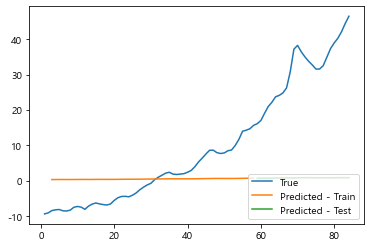

Epochs:  10  Iterations:  11  RMSE Loss:  5.370893462174729


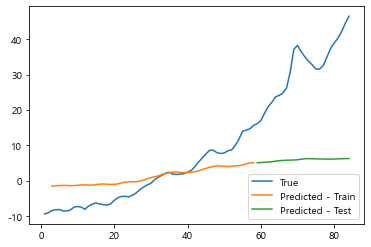

Epochs:  20  Iterations:  21  RMSE Loss:  2.558233757027869


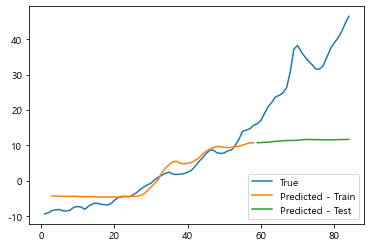

Epochs:  30  Iterations:  31  RMSE Loss:  2.531495635747491


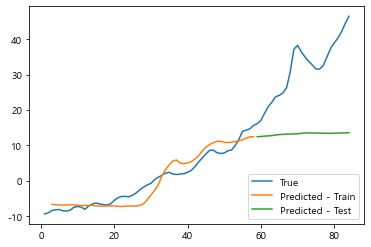

Epochs:  40  Iterations:  41  RMSE Loss:  1.83921100078477


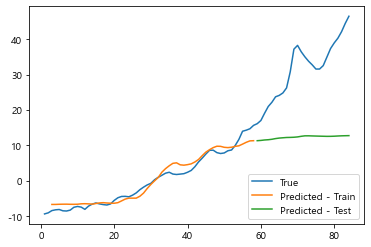

Epochs:  50  Iterations:  51  RMSE Loss:  1.6875262788209924


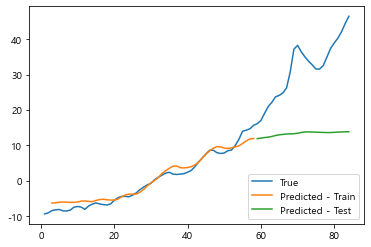

Epochs:  60  Iterations:  61  RMSE Loss:  1.438812568821969


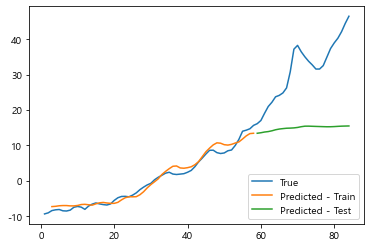

Epochs:  70  Iterations:  71  RMSE Loss:  1.2769236209106347


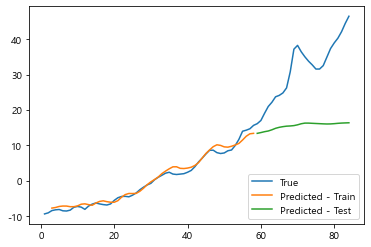

Epochs:  80  Iterations:  81  RMSE Loss:  1.16805927857118


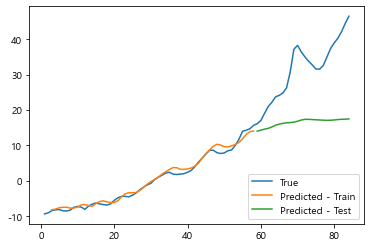

Epochs:  90  Iterations:  91  RMSE Loss:  1.0976605398291117


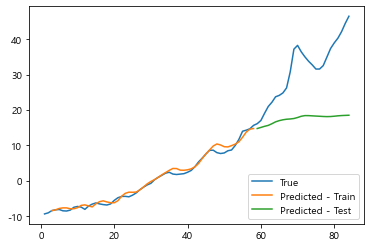

Epochs:  100  Iterations:  101  RMSE Loss:  1.0456412147774201


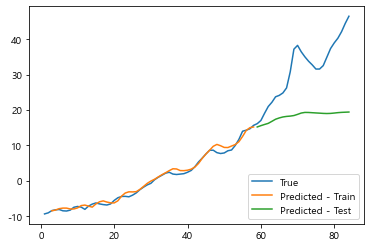

Epochs:  110  Iterations:  111  RMSE Loss:  0.9990269874367983


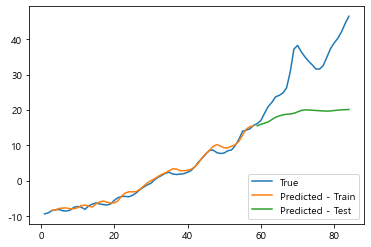

Epochs:  120  Iterations:  121  RMSE Loss:  0.9779991873365275


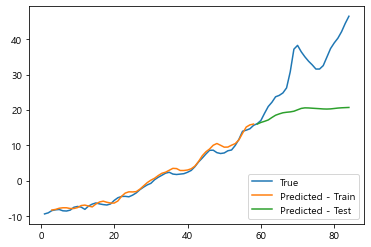

Epochs:  130  Iterations:  131  RMSE Loss:  0.9211431604904732


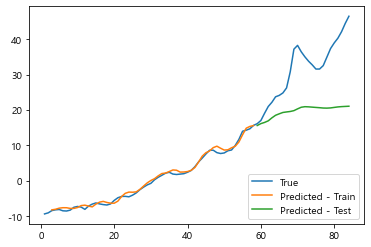

Epochs:  140  Iterations:  141  RMSE Loss:  0.8986499037730943


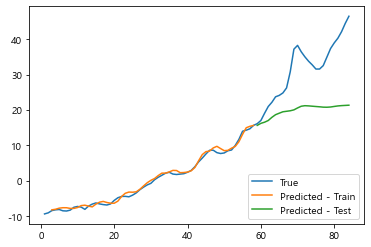

Epochs:  150  Iterations:  151  RMSE Loss:  0.9087409939116332


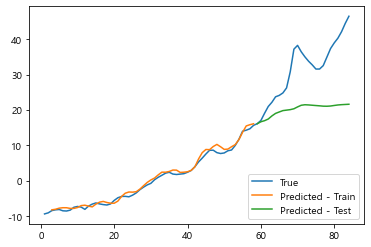

Epochs:  160  Iterations:  161  RMSE Loss:  0.8697949635943824


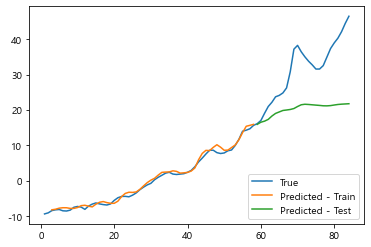

Epochs:  170  Iterations:  171  RMSE Loss:  0.8718398794668503


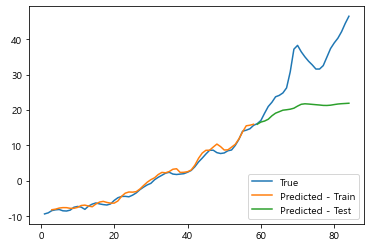

Epochs:  180  Iterations:  181  RMSE Loss:  0.8685360981363234


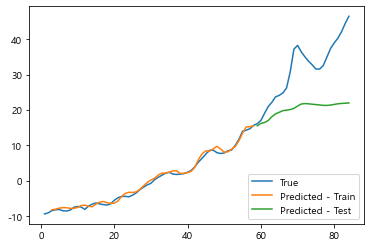

Epochs:  190  Iterations:  191  RMSE Loss:  0.8633557455794151


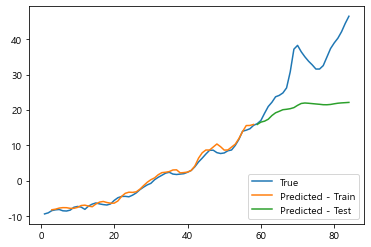

Epochs:  200  Iterations:  201  RMSE Loss:  0.8517513940574136


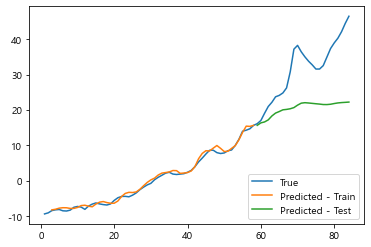

Epochs:  210  Iterations:  211  RMSE Loss:  0.8584058672308941


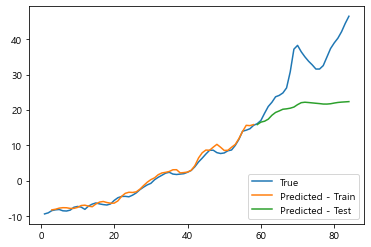

Epochs:  220  Iterations:  221  RMSE Loss:  0.8388251226356696


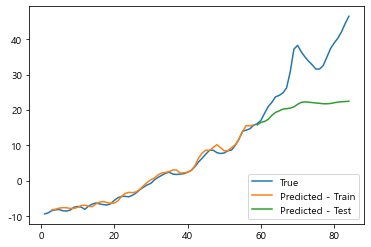

Epochs:  230  Iterations:  231  RMSE Loss:  0.8388920559377726


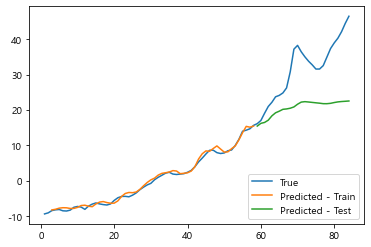

Epochs:  240  Iterations:  241  RMSE Loss:  0.8319408385535293


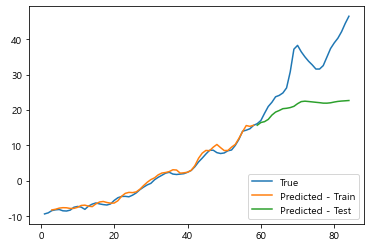

Epochs:  250  Iterations:  251  RMSE Loss:  0.8364892012497072


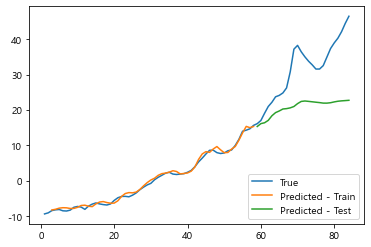

Epochs:  260  Iterations:  261  RMSE Loss:  0.8254324848701179


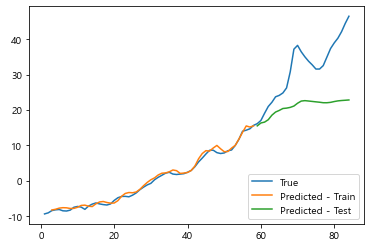

Epochs:  270  Iterations:  271  RMSE Loss:  0.829857291971425


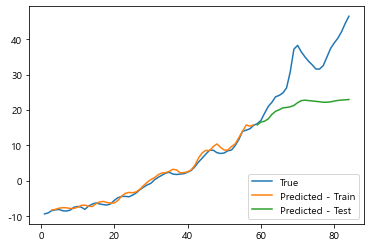

Epochs:  280  Iterations:  281  RMSE Loss:  0.8312905466616682


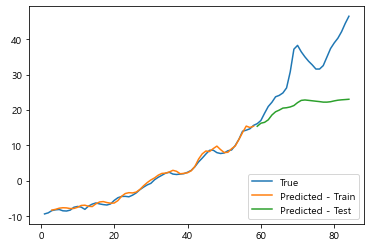

Epochs:  290  Iterations:  291  RMSE Loss:  0.8407591687875667


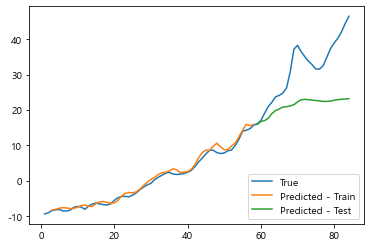

Epochs:  300  Iterations:  301  RMSE Loss:  0.8261565078496576


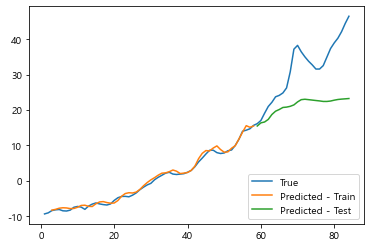

Epochs:  310  Iterations:  311  RMSE Loss:  0.8090077690156992


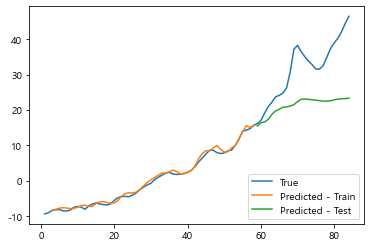

Epochs:  320  Iterations:  321  RMSE Loss:  0.812082880495303


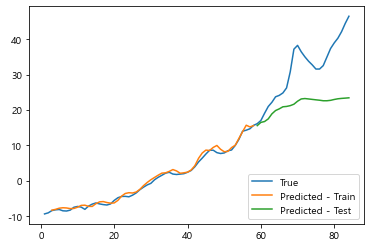

Epochs:  330  Iterations:  331  RMSE Loss:  0.8250278280362119


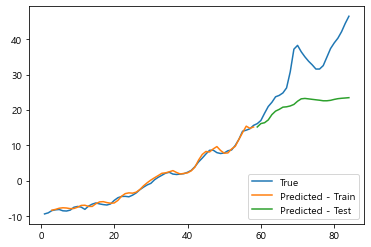

Epochs:  340  Iterations:  341  RMSE Loss:  0.8172575605129675


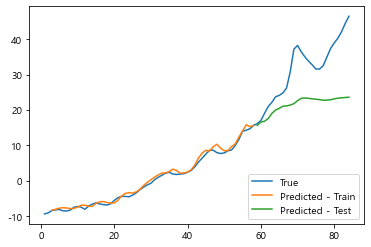

Epochs:  350  Iterations:  351  RMSE Loss:  0.8286096126585333


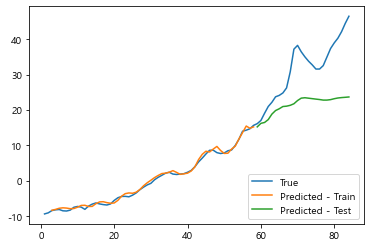

Epochs:  360  Iterations:  361  RMSE Loss:  0.8213038675649819


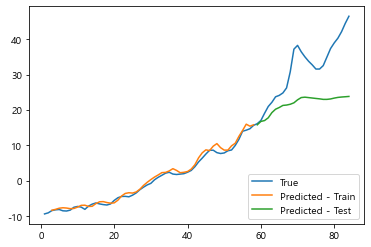

Epochs:  370  Iterations:  371  RMSE Loss:  0.8136183671210612


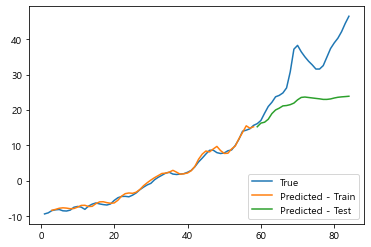

Epochs:  380  Iterations:  381  RMSE Loss:  0.7970632816856162


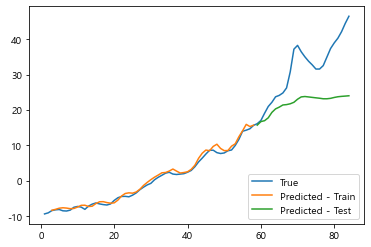

Epochs:  390  Iterations:  391  RMSE Loss:  0.7887553759843581


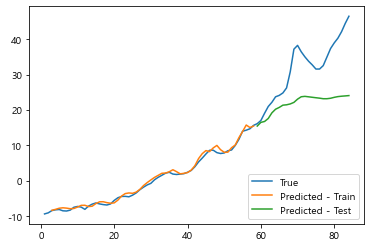

Epochs:  400  Iterations:  401  RMSE Loss:  0.7857120880802186


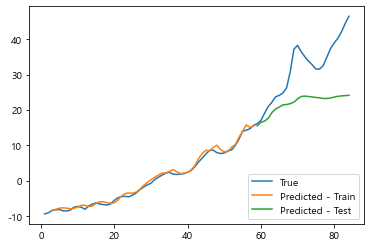

Epochs:  410  Iterations:  411  RMSE Loss:  0.8442569551890232


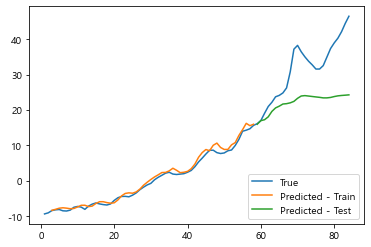

Epochs:  420  Iterations:  421  RMSE Loss:  0.7839347865487982


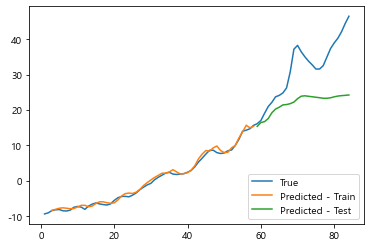

Epochs:  430  Iterations:  431  RMSE Loss:  0.8014108927163306


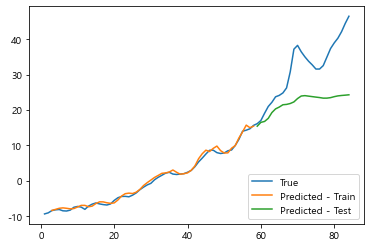

Epochs:  440  Iterations:  441  RMSE Loss:  0.777630087098316


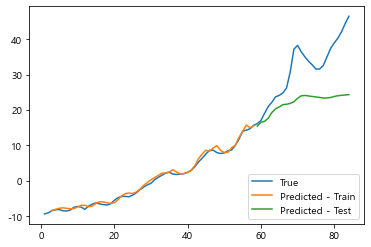

Epochs:  450  Iterations:  451  RMSE Loss:  0.7784471587964327


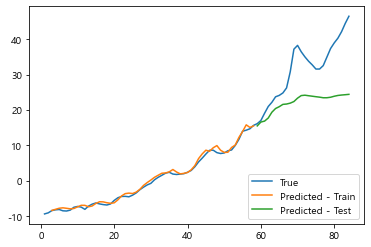

Epochs:  460  Iterations:  461  RMSE Loss:  0.8201435823456092


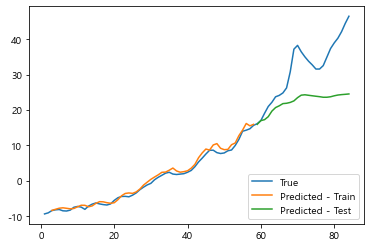

Epochs:  470  Iterations:  471  RMSE Loss:  0.7790315028028802


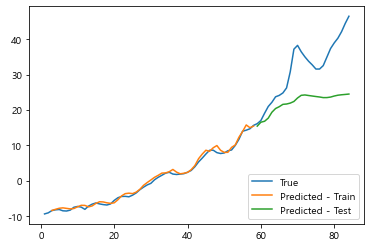

Epochs:  480  Iterations:  481  RMSE Loss:  0.7684577386338719


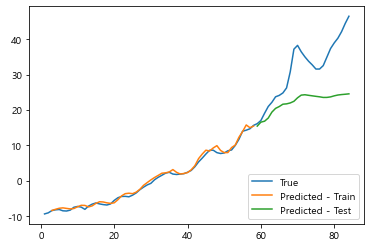

Epochs:  490  Iterations:  491  RMSE Loss:  0.7696781308730264


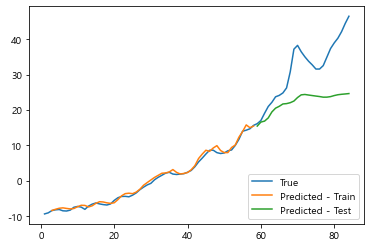

Epochs:  500  Iterations:  501  RMSE Loss:  0.7834099855525263


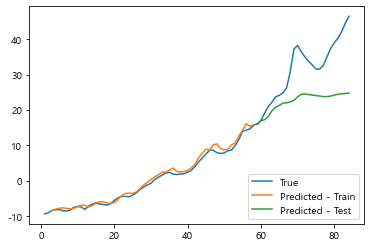

Epochs:  510  Iterations:  511  RMSE Loss:  0.8115166802704536


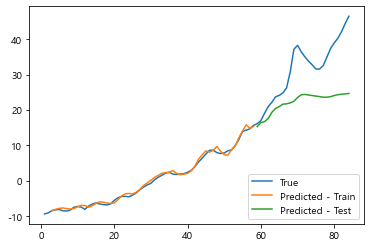

Epochs:  520  Iterations:  521  RMSE Loss:  0.771273427202485


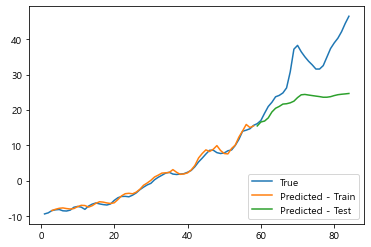

Epochs:  530  Iterations:  531  RMSE Loss:  0.7636387029989748


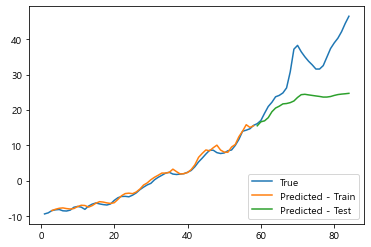

Epochs:  540  Iterations:  541  RMSE Loss:  0.7590163588840421


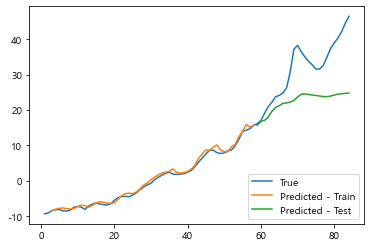

Epochs:  550  Iterations:  551  RMSE Loss:  0.754468875912966


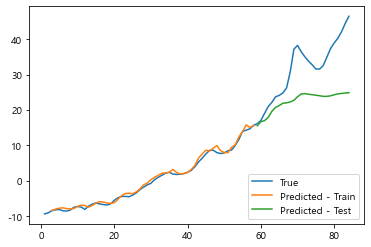

Epochs:  560  Iterations:  561  RMSE Loss:  0.7508750023394947


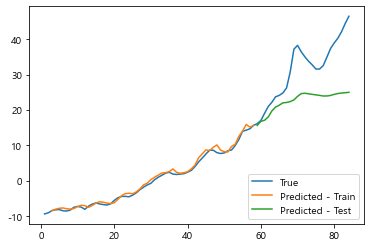

Epochs:  570  Iterations:  571  RMSE Loss:  0.7568301096045777


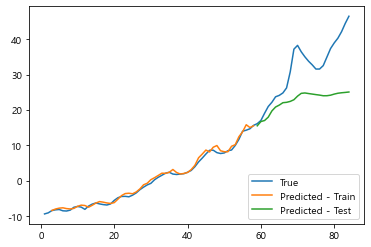

Epochs:  580  Iterations:  581  RMSE Loss:  0.78677455700374


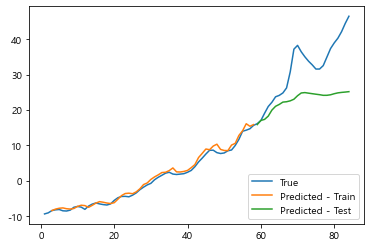

Epochs:  590  Iterations:  591  RMSE Loss:  0.7493649814371885


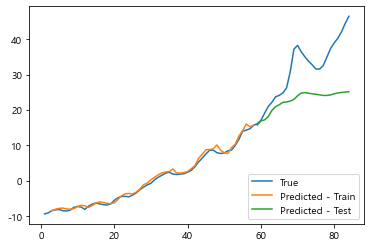

Epochs:  600  Iterations:  601  RMSE Loss:  0.7418019146419118


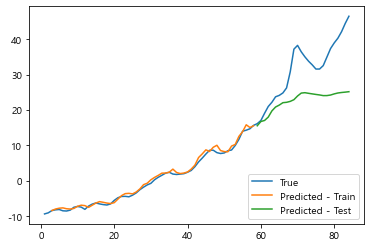

Epochs:  610  Iterations:  611  RMSE Loss:  0.7458782983434957


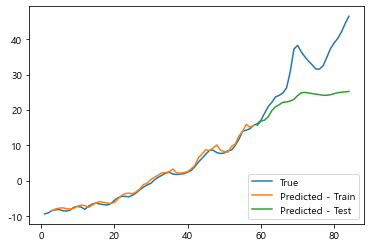

Epochs:  620  Iterations:  621  RMSE Loss:  0.753263960875114


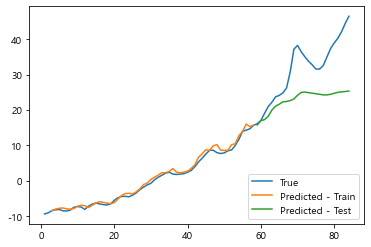

Epochs:  630  Iterations:  631  RMSE Loss:  0.7915746150123164


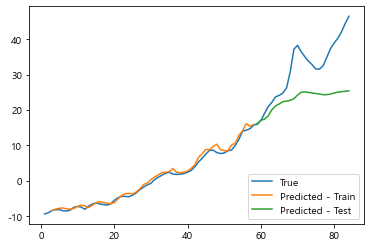

Epochs:  640  Iterations:  641  RMSE Loss:  0.7380485369737394


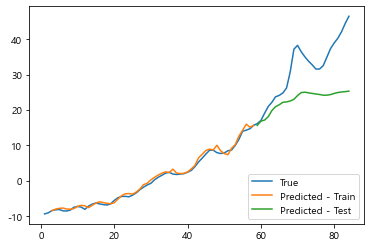

Epochs:  650  Iterations:  651  RMSE Loss:  0.7352681916939481


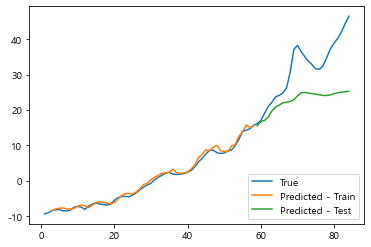

Epochs:  660  Iterations:  661  RMSE Loss:  0.7355722448316264


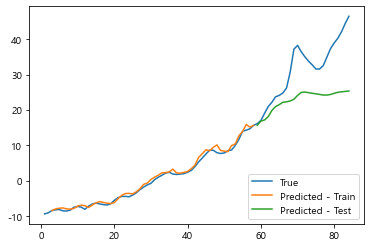

Epochs:  670  Iterations:  671  RMSE Loss:  0.731612915883002


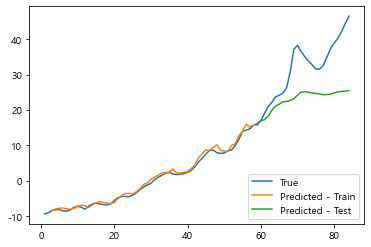

Epochs:  680  Iterations:  681  RMSE Loss:  0.7328836434973875


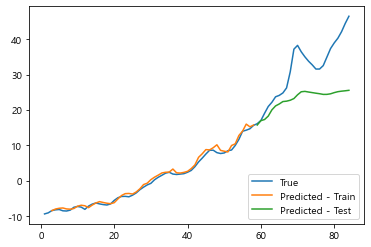

Epochs:  690  Iterations:  691  RMSE Loss:  0.7447131099931562


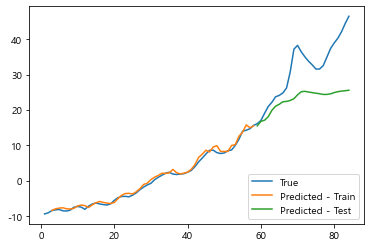

Epochs:  700  Iterations:  701  RMSE Loss:  0.9741862875172862


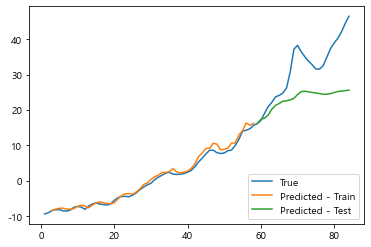

Epochs:  710  Iterations:  711  RMSE Loss:  0.7699992117320398


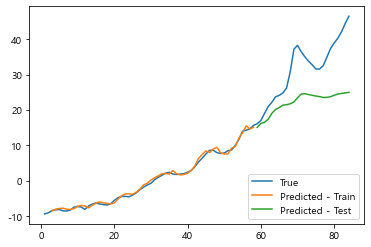

Epochs:  720  Iterations:  721  RMSE Loss:  0.7426083225007853


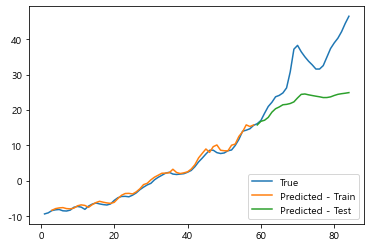

Epochs:  730  Iterations:  731  RMSE Loss:  0.7266408406343337


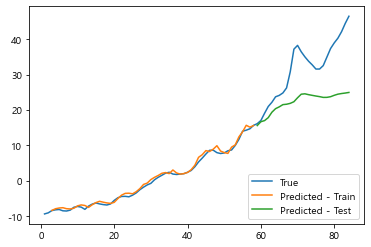

Epochs:  740  Iterations:  741  RMSE Loss:  0.7214793338816381


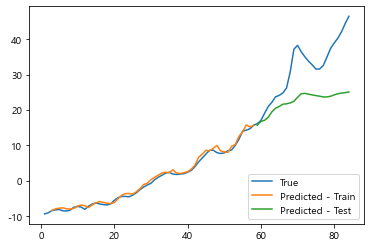

Epochs:  750  Iterations:  751  RMSE Loss:  0.7156602542639078


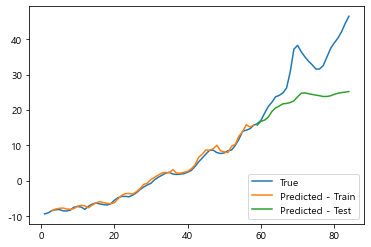

Epochs:  760  Iterations:  761  RMSE Loss:  0.7117761130304381


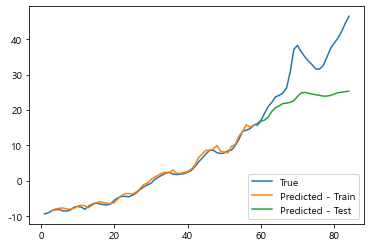

Epochs:  770  Iterations:  771  RMSE Loss:  0.7074671713420799


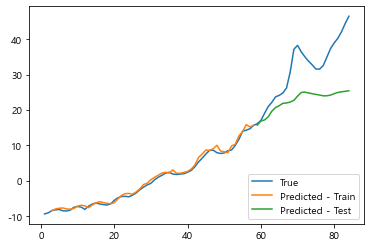

Epochs:  780  Iterations:  781  RMSE Loss:  0.7083180977547899


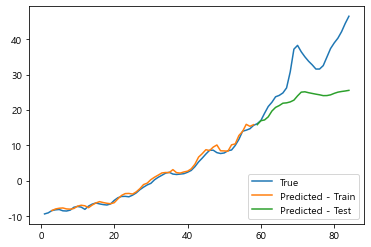

Epochs:  790  Iterations:  791  RMSE Loss:  0.7049343142108985


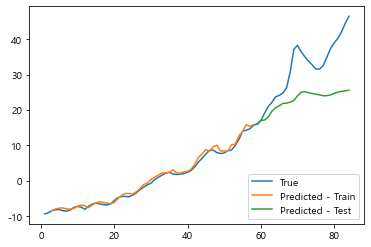

Epochs:  800  Iterations:  801  RMSE Loss:  0.7408505092413393


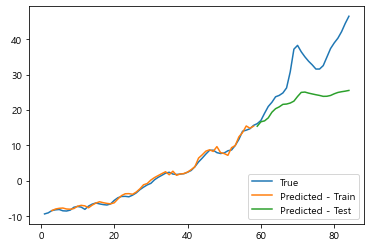

Epochs:  810  Iterations:  811  RMSE Loss:  0.711456067783068


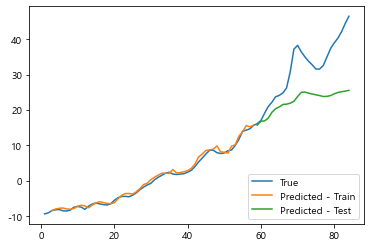

Epochs:  820  Iterations:  821  RMSE Loss:  0.8076224644037665


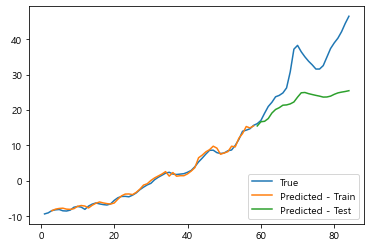

Epochs:  830  Iterations:  831  RMSE Loss:  0.7417474747329684


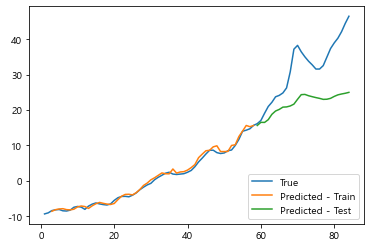

Epochs:  840  Iterations:  841  RMSE Loss:  0.7117278767407792


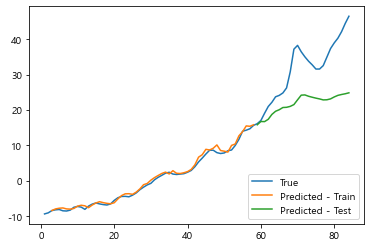

Epochs:  850  Iterations:  851  RMSE Loss:  0.6903001159206439


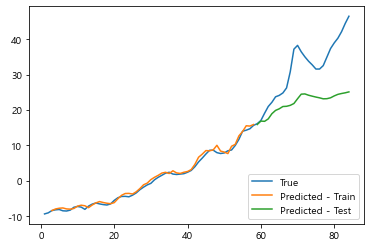

Epochs:  860  Iterations:  861  RMSE Loss:  0.6840143054489596


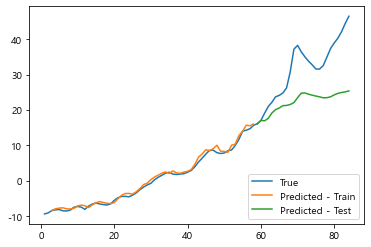

Epochs:  870  Iterations:  871  RMSE Loss:  0.6774858794201246


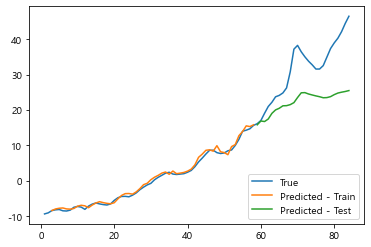

Epochs:  880  Iterations:  881  RMSE Loss:  0.7030211689896846


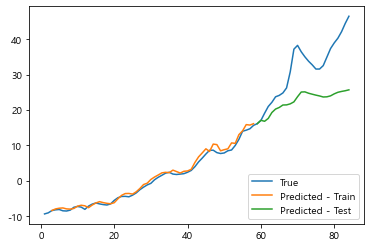

Epochs:  890  Iterations:  891  RMSE Loss:  0.7684010372687056


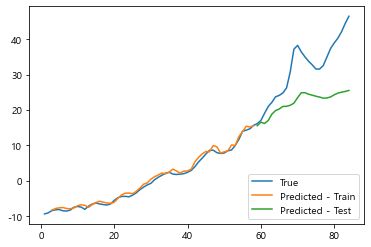

Epochs:  900  Iterations:  901  RMSE Loss:  0.7851772020875151


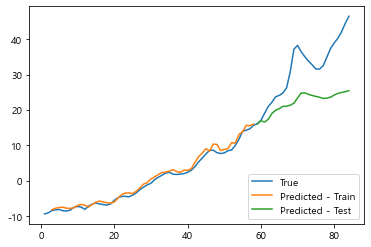

Epochs:  910  Iterations:  911  RMSE Loss:  0.7691439510833444


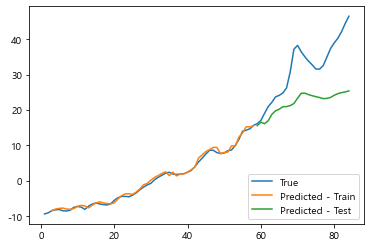

Epochs:  920  Iterations:  921  RMSE Loss:  0.7005258628541761


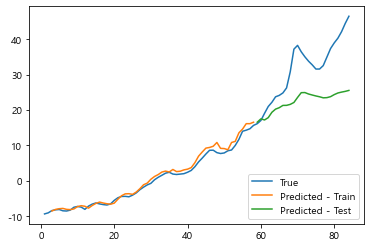

Epochs:  930  Iterations:  931  RMSE Loss:  0.6933985954259989


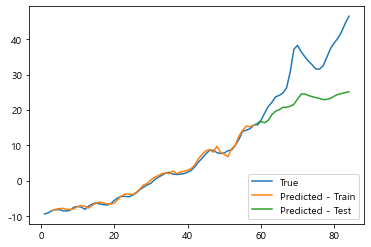

Epochs:  940  Iterations:  941  RMSE Loss:  0.6688249020208631


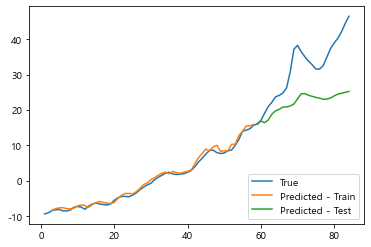

Epochs:  950  Iterations:  951  RMSE Loss:  0.6665443939096277


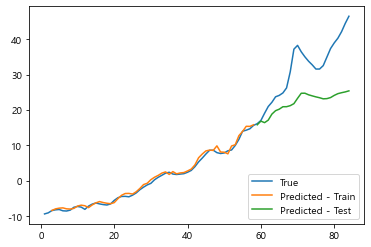

Epochs:  960  Iterations:  961  RMSE Loss:  0.657135456906879


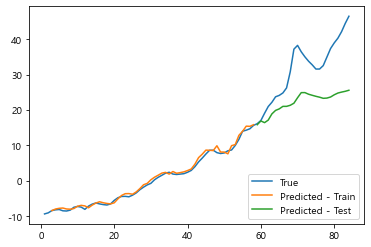

Epochs:  970  Iterations:  971  RMSE Loss:  0.6560331622150227


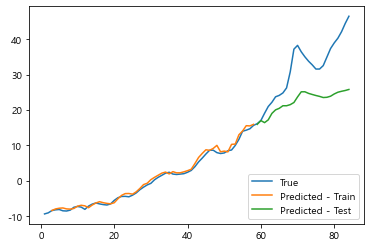

Epochs:  980  Iterations:  981  RMSE Loss:  0.6704636543416329


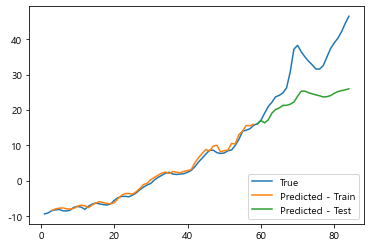

Epochs:  990  Iterations:  991  RMSE Loss:  0.667348450983773


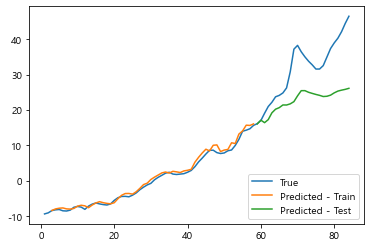

Finished Training


In [12]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)



print("==> Load dataset ...")
# Initialize model
print("==> Initialize DA-RNN model ...")
model = DA_rnn(
    X,
    y,
    ntimestep,
    nhidden_encoder,
    nhidden_decoder,
    batchsize,
    lr,
    epochs
)

# Train
print("==> Start training ...")
model.train()

# Prediction
y_pred = model.test()


print('Finished Training')

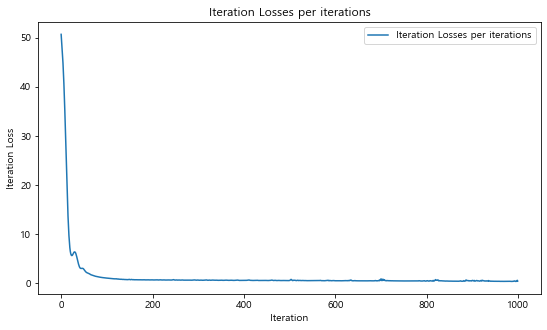

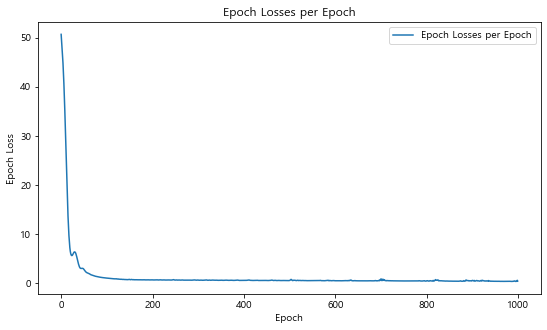

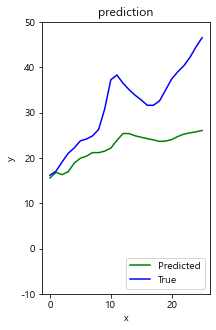

In [13]:
fig1 = plt.figure(figsize=(9,5))
grid1 = fig1.add_subplot(1,1,1)
grid1.plot(model.iter_losses, label='Iteration Losses per iterations')
grid1.set_title('Iteration Losses per iterations')
grid1.set_xlabel('Iteration', fontsize=10)
grid1.set_ylabel('Iteration Loss',fontsize=10)
grid1.legend(loc='upper right')
plt.show()



fig2 = plt.figure(figsize=(9,5))
grid2 = fig2.add_subplot(1,1,1)
grid2.plot(model.epoch_losses, label='Epoch Losses per Epoch')
grid2.set_title('Epoch Losses per Epoch')
grid2.set_xlabel('Epoch', fontsize=10)
grid2.set_ylabel('Epoch Loss',fontsize=10)
grid2.legend(loc='upper right')
plt.show()



fig3 = plt.figure(figsize=(3,5))
grid3 = fig3.add_subplot(1,1,1)
grid3.plot(y_pred, label='Predicted', color='g')
grid3.plot(model.y[model.train_timesteps:], label='True', color='b')
grid3.set_title('prediction')
grid3.set_xlabel('x', fontsize=10)
grid3.set_ylabel('y',fontsize=10)
grid3.set_ylim([-10,50])
grid3.legend(loc='lower right')
plt.show()

In [14]:
# fig1 = plt.figure()
# plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
# plt.show()
# # plt.savefig("./1.png",dpi=300)
# # plt.close(fig1)

# fig2 = plt.figure()
# plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
# plt.show()
# # plt.savefig("./2.png",dpi=300))
# # plt.close(fig2)

# fig3 = plt.figure()
# plt.plot(y_pred, label='Predicted')
# plt.plot(model.y[model.train_timesteps:], label="True")
# plt.legend(loc='upper left')
# plt.show()
# # plt.savefig("./3.png",dpi=300)
# # plt.close(fig3)

# 파라미터 최종
* batchsize = 64
* nhidden_encoder = 256
* nhidden_decoder = 256
* ntimestep = 3
* lr = 0.003
* epochs = 1000

In [15]:
# help(nn.LSTM)